# The plan
* Import the data from the flat CSV
* Preprocess the relevant fields to remove junk
* Construct a graph of the most important relationships
* Pass that graph into a node2vec constructor so to generate random walks
* Fit these sequences with a word2vec model, and save to another CSV
* Extract the embeddings, and visualise them

In [1]:
# Data handling and processing 
import pandas as pd
from node2vec import Node2Vec
import networkx as nx
from gensim.models import Word2Vec
pd.options.mode.chained_assignment = None

# For visualizing the embeddings
from sklearn.manifold import MDS 
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
%matplotlib inline

# Helper utilities, and parsing of inputs
from tqdm import tqdm
import ast
import re
from unidecode import unidecode 

# Fetch and preprocess the data
The original dataset has 2 million rows in it, so this might take a while. The original data can be found by following the link in the README.

In [2]:
# A helper function for preprocessing the rows of this dataset:
def process_text(string):
    # convert it to a python object
    tokenized = ast.literal_eval(string.lower())
    
    # remove some junk characters
    filtered = [unidecode(string).lower() for string in tokenized]
    filtered = [re.sub(r'[^\w ]+', '', string) for string in filtered]
    filtered = [re.sub(r'[\-\_0-9]+', ' ', string) for string in filtered]
    
    # strip whitespace
    stripped = [string.strip() for string in filtered]
    
    # remove empty strings
    result = [string for string in stripped if string]
    
    return result

# Read the file in as as pandas DF
# How many rows of this huge dataset do we want? 1.0 = all of them
fraction = 0.75
print("Loading data from disk")
data = pd.read_csv('./data/full_dataset.csv',
                   usecols = ['title', 'ingredients', 'directions', 'NER']
                  ).sample(frac = fraction)

# Use the function defined above to convert the list of string representations into a list of lists
tokenized = [process_text(string) for string in tqdm(data['NER'].tolist(), desc = 'tokenizing')]

# How many ingredients are we working with? And how are they distributed?
ingredients = {}
for recipe in tqdm(tokenized, desc = 'tallying'):
    for ingredient in recipe: 
        if ingredient not in ingredients.keys(): 
            ingredients[ingredient] = 1
        else: 
            ingredients[ingredient] += 1

Loading data from disk


tallying: 100%|███████████████████| 1673356/1673356 [00:03<00:00, 452586.67it/s]


In [3]:
# Make it into a pandas dataframe
ingredients_df = pd.DataFrame({"cleaned_ingredients": key, "recipes":value} for key,value in ingredients.items())
ingredients_df.to_csv('ingredient_counts.csv', header = True, index = False)

In [4]:
data['cleaned_ingredients'] = tokenized
data['id'] = data.index

In [5]:
# Explode the list of ingredients for each recipe so we can filter and self-join later
print('exploding')
exploded = data[['id', 'cleaned_ingredients']].explode(column = 'cleaned_ingredients')


# Remove ingredients that appear in fewer than n_recipes in total
print('filtering ingredients')
n_recipes = 1000
reduced = (ingredients_df[ingredients_df['recipes'] > n_recipes]
           .sort_values('recipes', 
                        axis = 0, 
                        ascending = 
                        False)[['cleaned_ingredients']]
          )

# Use the reduced list to filter down the exploded ingredients
exploded = pd.merge(exploded, 
                    reduced, 
                    on = 'cleaned_ingredients', 
                    how = 'inner'
                   )

# Construct edges with a self join
edges = pd.merge(exploded, 
                 exploded, on = 'id')

# Remove self-loops
edges = edges[edges['cleaned_ingredients_x'] != edges['cleaned_ingredients_y']]

# Aggregate edges into a weights column
print("aggregating edges")
edges = (edges
         .groupby(['cleaned_ingredients_x', 'cleaned_ingredients_y'])
         .size()
         .reset_index(name = 'weight')
        )

# Should we filter out sparse edges (ingredients that occur very infrequently with each other)?
edge_weight = 10
edges_filtered = edges[edges['weight']>=edge_weight]

# Scale the edge weights a bit so we're not working with huge numbers
edges_filtered['weight'] = edges_filtered['weight'] / max(edges_filtered['weight'])

exploding
filtering ingredients
aggregating edges


In [6]:
g = (nx
     .convert_matrix
     .from_pandas_edgelist(edges_filtered, 
                           source = 'cleaned_ingredients_x', 
                           target = 'cleaned_ingredients_y',
                           edge_attr = True)
            .to_undirected()
    )

In [7]:
print(max([b for (a,b) in list(g.degree())]))
print(len(g.nodes()))

986
987


In [8]:
# We bias the random walk to explore nearby so that it finds ingredients that 
# may be good together.
nv = Node2Vec(g, 
              walk_length=50, 
              num_walks=200, 
              workers=12,
              p=1.5,
              q=0.5,
              weight_key = 'weight'
             ) 

Generating walks (CPU: 12): 100%|██████████| 16/16 [02:11<00:00,  8.23s/it]


In [16]:
# We use Word2Vec directly instead of Node2Vec because of a keyword bug in this 
# version of the N2V implementation.
fit = Word2Vec(sentences=nv.walks, 
               vector_size=32, 
               window=10, 
               min_count=1, 
               workers=12)

In [17]:
ingredients = ['butter', 'brown sugar']
print(fit.wv.most_similar(positive = ingredients, topn=3))

[('white sugar', 0.8105787038803101), ('flour', 0.7960872650146484), ('eggs', 0.7912474870681763)]


# Clustering
Split the vectors into clusters with k-means, and then store everything as a CSV

In [18]:
# Slap a K-means model in there to group them into buckets
kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(fit.wv.vectors)

# Save the vectors as a CSV file for later
vectors = dict(zip(fit.wv.index_to_key,[list(vector) for vector in list(fit.wv.vectors)]))
vectors_df = pd.DataFrame(vectors).T
vectors_df.reset_index(inplace = True)
vectors_df.columns = [str(col) for col in vectors_df.columns]
vectors_df.set_index('index', inplace = True)
vectors_df['cluster'] = kmeans
vectors_df.to_csv("food_vectors.csv", header = True, index = False)

# Visualisation

In [19]:
labels = []
tokens = []
sizes = []
colors = []

for word in fit.wv.index_to_key:
    tokens.append(fit.wv[word])
    labels.append(word)
    sizes.append((ingredients_df[ingredients_df['cleaned_ingredients']==word].recipes)**0.25)
    colors.append(vectors_df.loc[word]['cluster'])
    
# Only add labels that are of a given magnitude
labels_filtered = []
for (name, size) in zip(labels, sizes): 
    if size.values[0] >= 7: 
        labels_filtered.append(name) 
    else:
        labels_filtered.append(None)

In [24]:
# Use Multi-dimensional Scaling to take these word vectors and project them into 3 dimensions
model = MDS(n_components=3, 
            random_state=42,
            n_jobs = 12)

new_values = model.fit_transform(tokens)

x = []
y = []
z = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    z.append(value[2])
    

In [25]:
visuals_df = pd.DataFrame({"x":x, "y":y, "z":z, "ingredient":labels, "size":[size.values[0] for size in sizes], "cluster":colors})
visuals_df.to_csv("visuals.csv", header = True, index = False)

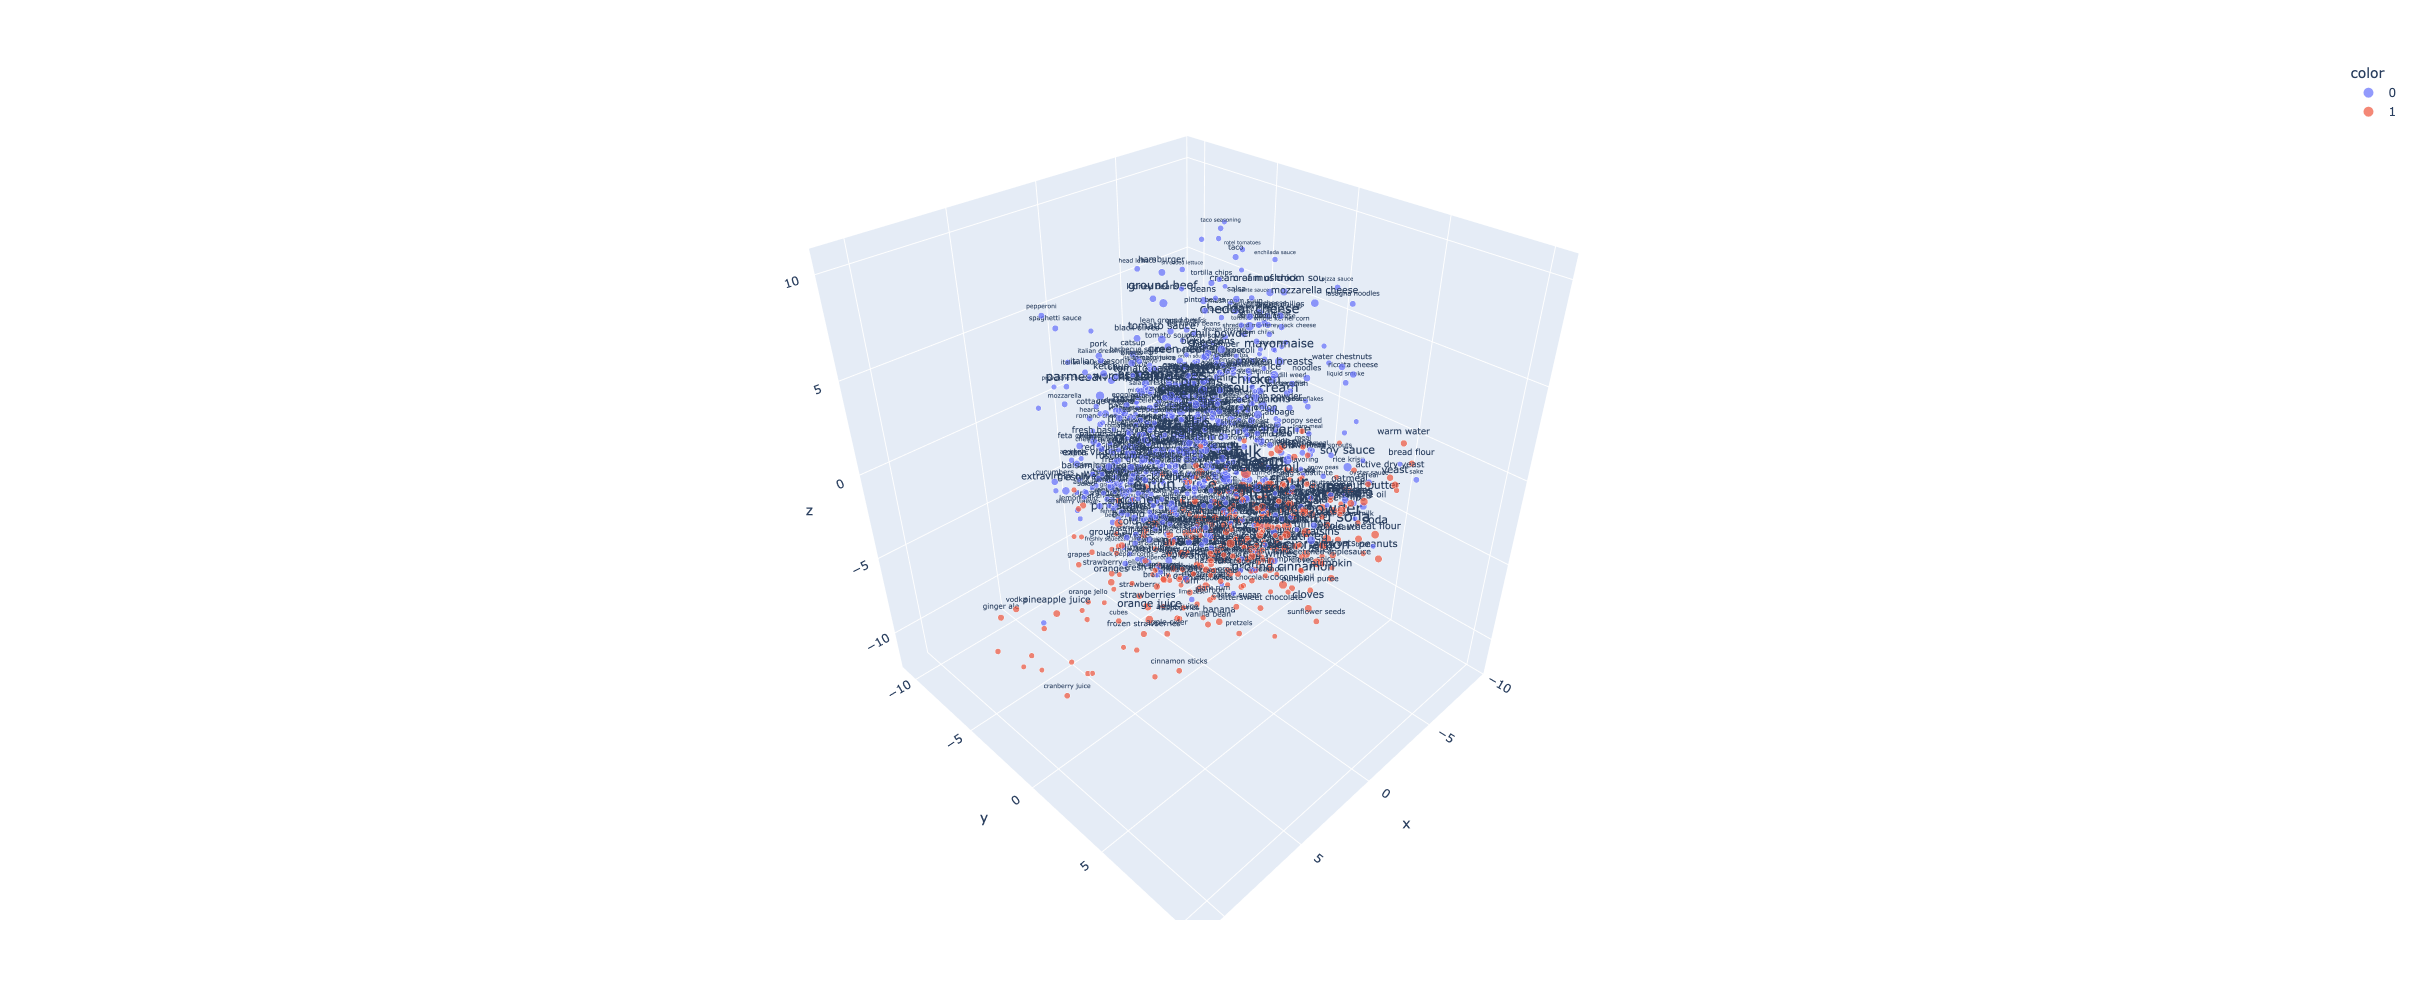

In [21]:
# Plot the figure
fig = px.scatter_3d(
    x=x, y=y, z=z,
    size = [s.values[0] for s in sizes],
    text=labels_filtered,
    height = 1000, 
    width = 1400, 
    color = [str(elem) for elem in kmeans]
)

fig.update_traces(
    textfont_size=[s.values[0]/1.5 for s in sizes]
)
fig.show()